## Notebook for analysing and predicting credit card customer churn

We are given a dataset which has customers and their status as being either existing customer or a churned out customer. There are several features in the dataset which can be used to find ways of modeling the churn of a customer.

Businesses use churn modeling to reduce the number of customers that drop out for good, thus increasing profits. If we can predict whether a customer will churn out as a customer, we can try to salvage the situation with different strategies, such as targeted campaigns or benefits.

In [61]:
# Data wrangle
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
sns.set_palette('gist_earth_r',n_colors=8)
import matplotlib.pyplot as plt

# Modeling
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder

from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.metrics import classification_report, roc_curve,auc, confusion_matrix

import warnings


warnings.filterwarnings("ignore")
%matplotlib inline


### Read the data

Data from Kaggle https://www.kaggle.com/sakshigoyal7/credit-card-customers, and more precisely that data is from  https://leaps.analyttica.com/home

In [62]:
df = pd.read_csv("../Data/BankChurners.csv",index_col=[0])
df.T.head(23)

,0,1,2,3,4,5,6,7,8,9,...,10117,10118,10119,10120,10121,10122,10123,10124,10125,10126
CLIENTNUM,768805383,818770008,713982108,769911858,709106358,713061558,810347208,818906208,710930508,719661558,...,712503408,713755458,716893683,710841183,713899383,772366833,710638233,716506083,717406983,714337233
Attrition_Flag,Existing Customer,Existing Customer,Existing Customer,Existing Customer,Existing Customer,Existing Customer,Existing Customer,Existing Customer,Existing Customer,Existing Customer,...,Existing Customer,Attrited Customer,Attrited Customer,Existing Customer,Existing Customer,Existing Customer,Attrited Customer,Attrited Customer,Attrited Customer,Attrited Customer
Customer_Age,45,49,51,40,40,44,51,32,37,48,...,57,50,55,54,56,50,41,44,30,43
Gender,M,F,M,F,M,M,M,M,M,M,...,M,M,F,M,F,M,M,F,M,F
Dependent_count,3,5,3,4,3,2,4,0,3,2,...,2,1,3,1,1,2,2,1,2,2
Education_Level,High School,Graduate,Graduate,High School,Uneducated,Graduate,Unknown,High School,Uneducated,Graduate,...,Graduate,Unknown,Uneducated,High School,Graduate,Graduate,Unknown,High School,Graduate,Graduate
Marital_Status,Married,Single,Married,Unknown,Married,Married,Married,Unknown,Single,Single,...,Married,Unknown,Single,Single,Single,Single,Divorced,Married,Unknown,Married
Income_Category,$60K - $80K,Less than $40K,$80K - $120K,Less than $40K,$60K - $80K,$40K - $60K,$120K +,$60K - $80K,$60K - $80K,$80K - $120K,...,$80K - $120K,$80K - $120K,Unknown,$60K - $80K,Less than $40K,$40K - $60K,$40K - $60K,Less than $40K,$40K - $60K,Less than $40K
Card_Category,Blue,Blue,Blue,Blue,Blue,Blue,Gold,Silver,Blue,Blue,...,Blue,Blue,Blue,Blue,Blue,Blue,Blue,Blue,Blue,Silver
Months_on_book,39,44,36,34,21,36,46,27,36,36,...,40,36,47,34,50,40,25,36,36,25


### Exploratory Data Analysis (EDA)

Check the shape of the data, and drop the CLIENTNUM feature

In [63]:
df.drop(columns=["CLIENTNUM"],inplace=True)
df.shape

(10127, 20)

How many null values are there?

In [64]:
round((df.isnull().sum() * 100)/(df.shape[0]),3)

Attrition_Flag              0.0
Customer_Age                0.0
Gender                      0.0
Dependent_count             0.0
Education_Level             0.0
Marital_Status              0.0
Income_Category             0.0
Card_Category               0.0
Months_on_book              0.0
Total_Relationship_Count    0.0
Months_Inactive_12_mon      0.0
Contacts_Count_12_mon       0.0
Credit_Limit                0.0
Total_Revolving_Bal         0.0
Avg_Open_To_Buy             0.0
Total_Amt_Chng_Q4_Q1        0.0
Total_Trans_Amt             0.0
Total_Trans_Ct              0.0
Total_Ct_Chng_Q4_Q1         0.0
Avg_Utilization_Ratio       0.0
dtype: float64

There are no null values in the data. Let's map the target label to binary (0=no churn, 1= churned customer) and check the descriptive stats of the dataset

In [65]:
df["Attrition_Flag"] = df["Attrition_Flag"].map({"Existing Customer":0, "Attrited Customer":1})

In [66]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Attrition_Flag,10127.0,0.160660,0.367235,0.0,0.000,0.000,0.000,1.000
Customer_Age,10127.0,46.325960,8.016814,26.0,41.000,46.000,52.000,73.000
Dependent_count,10127.0,2.346203,1.298908,0.0,1.000,2.000,3.000,5.000
Months_on_book,10127.0,35.928409,7.986416,13.0,31.000,36.000,40.000,56.000
Total_Relationship_Count,10127.0,3.812580,1.554408,1.0,3.000,4.000,5.000,6.000
Months_Inactive_12_mon,10127.0,2.341167,1.010622,0.0,2.000,2.000,3.000,6.000
Contacts_Count_12_mon,10127.0,2.455317,1.106225,0.0,2.000,2.000,3.000,6.000
Credit_Limit,10127.0,8631.953698,9088.776650,1438.3,2555.000,4549.000,11067.500,34516.000
Total_Revolving_Bal,10127.0,1162.814061,814.987335,0.0,359.000,1276.000,1784.000,2517.000
Avg_Open_To_Buy,10127.0,7469.139637,9090.685324,3.0,1324.500,3474.000,9859.000,34516.000


Features 'Credit limit' and "Avg_Open_To_Buy" are quite interesting. The Standard deviation is larger than the mean for both of these features. This means that the values are significantly dispersed from the mean (long tailed distribution).

In addition, onlly 16% of the customers have churned, implying a big imbalance on the target labels.

### Visualize the categorical features

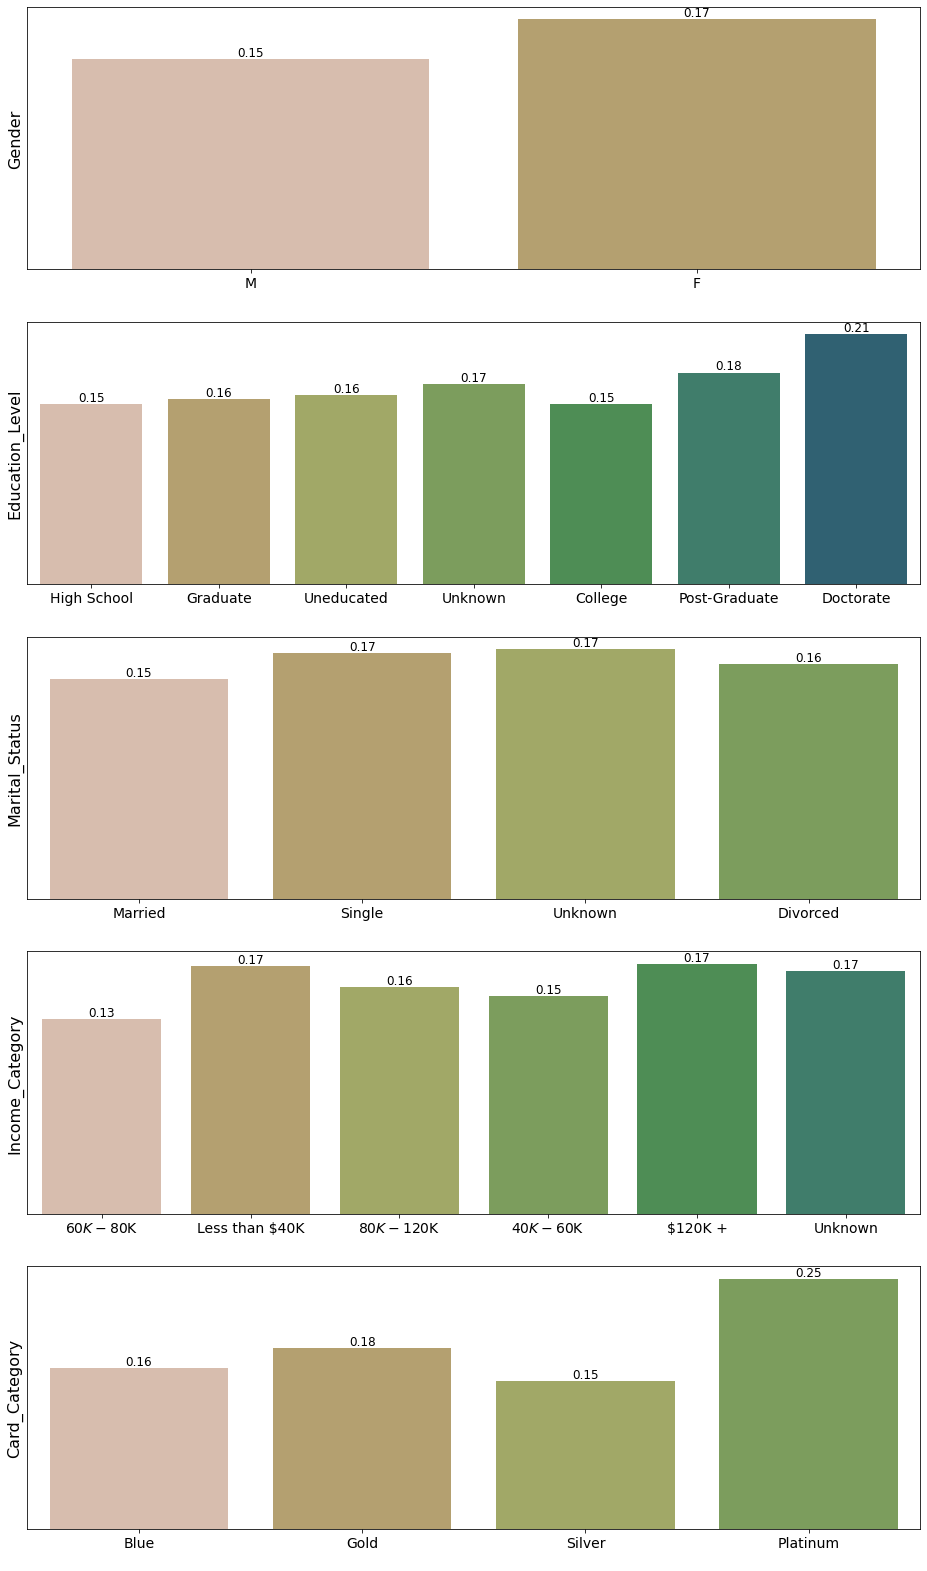

In [67]:
num_cols = list(df.select_dtypes([np.number]).columns)
cat_cols = [c for c in df.columns if c not in num_cols]


fig, ax = plt.subplots(ncols=1, nrows=5, figsize=(16, 28))
                
i = 0 #counter

for cols in cat_cols:
    sns.barplot(x=df[cols], y=df['Attrition_Flag'], fill=True, ci=None, ax=ax[i])
    

    # '#05386b', '#379683','#5cdb59','#8ee4af','#edf5e1'
    ax[i].set_xlabel(' ')
    ax[i].set_xlabel(' ')
    ax[i].set_ylabel(' ')
    ax[i].xaxis.set_tick_params(labelsize=14)
    ax[i].tick_params(left=False, labelleft=False)
    ax[i].set_ylabel(cols, fontsize=16)    
    ax[i].bar_label(ax[i].containers[0], size="12",fmt='%.2f')
    i=i+1

      
plt.show()

### Notes from categorical features

- Females have a slightly higher churn rate
- People with a doctorate degree have the highest churn rate
    - Almost seems like higher education level implies higher churn rate
- Single people have slightly higher churn rate
- People with annual income in the 60-80k range have the lowest churn rate
- "Platinum" card category customers have higher churn rate than other card categories

### Let's see the numerical features now

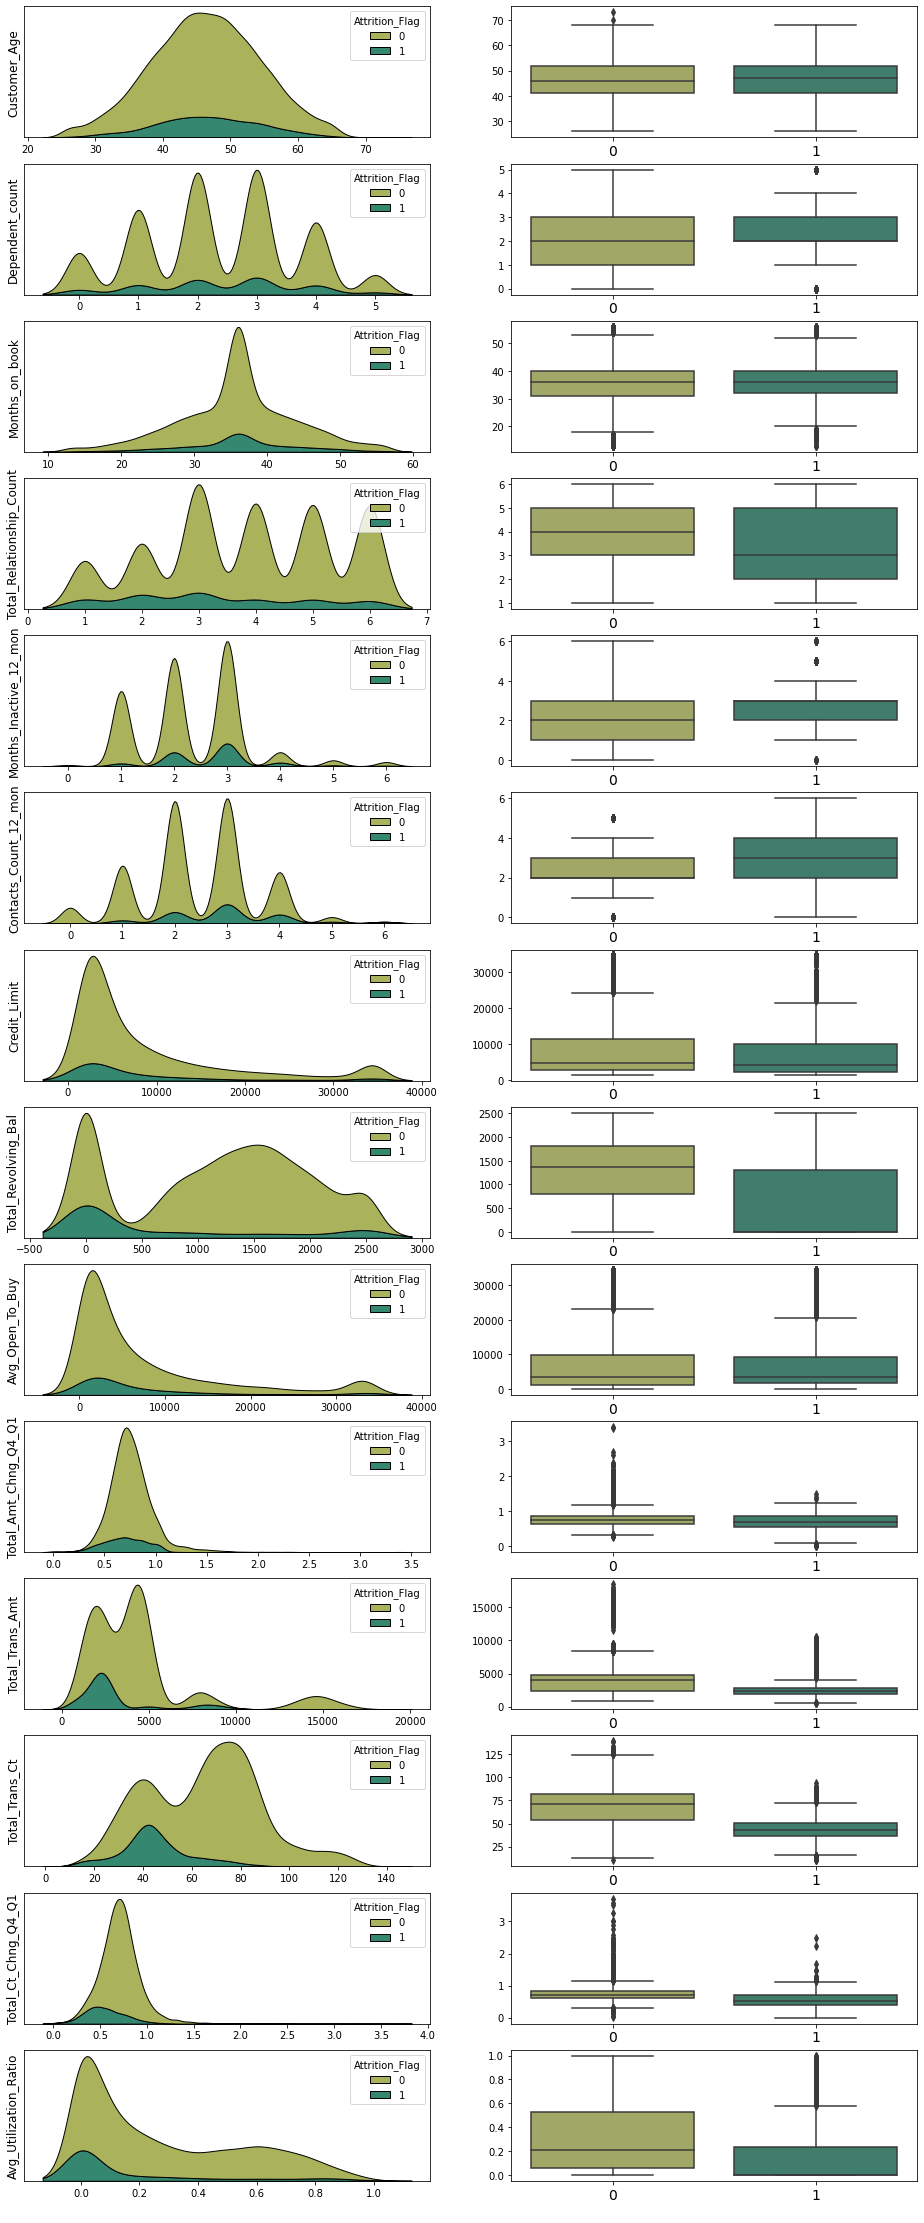

In [68]:
fig, ax = plt.subplots(ncols=2, nrows=14, figsize=(16, 40))
                
i = 0 #counter
for cols in num_cols[1:]:
    
    sns.kdeplot(df[cols] ,hue = df['Attrition_Flag'],alpha=1,fill=True, ax=ax[i,0],multiple='stack',palette=("gist_earth_r"))
    
    sns.boxplot(data= df, y=cols, x='Attrition_Flag', ax=ax[i, 1],palette=("gist_earth_r"), color='white')
    ax[i,0].set_xlabel(' ')
    ax[i,1].set_xlabel(' ')
    ax[i,1].set_ylabel(' ')
    ax[i,1].xaxis.set_tick_params(labelsize=14)
    ax[i,0].tick_params(left=False, labelleft=False)
    ax[i,0].set_ylabel(cols, fontsize=12)
    i=i+1
      
plt.show()

### Notes from numerical features

- Some features are quite different between churned and non-churned customers.
    - 'Total_Trans_Amt' & 'Total_Trans_Ct' show multimodal distributions for the existing customers, but unimodal for the churned customers.
    - The tails for some feature distributions of non-churned customers are longer. Good example would be 'Avg_Utilization_Ratio'.

### To get more insight into the underlying structure of the data, we can plot the correlations of the numerical features.

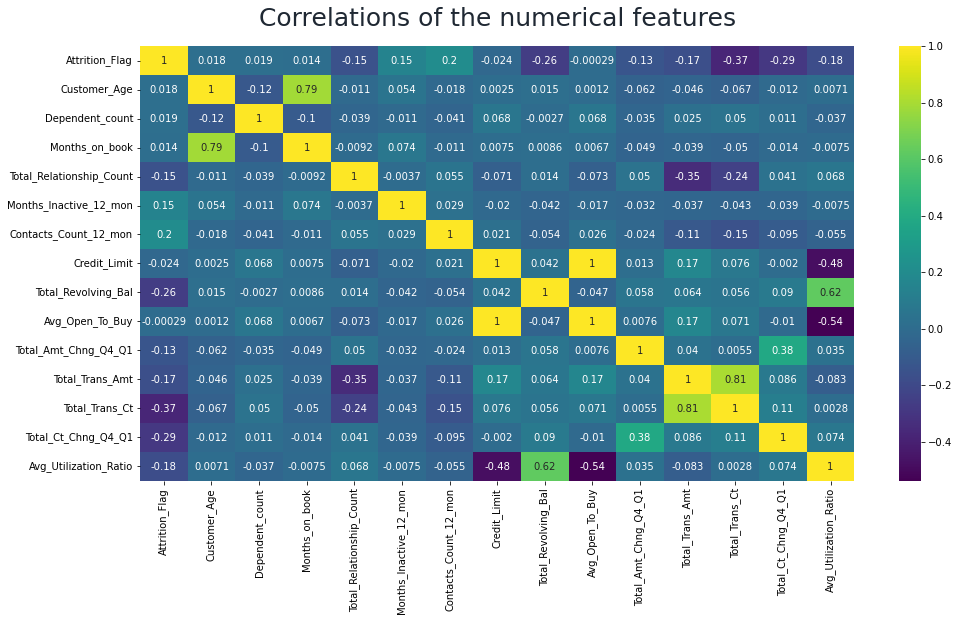

In [69]:
df_corr = df.corr()

plt.figure(figsize=[16,8])
plt.title("Correlations of the numerical features", size=25, pad=20, color='#1f2833')
sns.heatmap(df_corr, cmap="viridis", annot=True)
plt.show()


In [70]:
df_corr[['Attrition_Flag']].sort_values(by='Attrition_Flag',ascending=False)

,Attrition_Flag
Attrition_Flag,1.000000
Contacts_Count_12_mon,0.204491
Months_Inactive_12_mon,0.152449
Dependent_count,0.018991
Customer_Age,0.018203
Months_on_book,0.013687
Avg_Open_To_Buy,-0.000285
Credit_Limit,-0.023873
Total_Amt_Chng_Q4_Q1,-0.131063
Total_Relationship_Count,-0.150005


The Target label seems to correlate most with 
- Contacts_Count_12_mon (0.2)
- Total_Revolving_Bal (-0.26)
- Total_Ct_Chng_Q4_Q1 (-0.29)
- Total_Trans_Ct (-0.38)

In addition, 'Credit_Limit' & 'Avg_Open_To_Buy' have a perfect correlation (1). We can drop one of these features to reduce the complexity of our upcoming models, without sacrificing performance.

## Data preprocessing

First, let's split the data into train and test sets to prevent data leakage

In [71]:
y = df["Attrition_Flag"]
X = df.drop(columns=["Attrition_Flag"])

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=69)

If we were to convert the categorical features into one-hot encoded variables, would our feature space be too sparse?

In [72]:
X[cat_cols].nunique()

Gender             2
Education_Level    7
Marital_Status     4
Income_Category    6
Card_Category      4
dtype: int64

The number of unique values for each categorical feature is relatively small, and thus we can confidently use one-hot encoding.

In [73]:
num_cols2 = list(filter(lambda x: x!='Attrition_Flag', num_cols)) 
cat_idx = X.columns.get_indexer(cat_cols)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", MinMaxScaler(), num_cols2),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_idx),
    ]
)

Apply the preprocessing:

1. First fit and transform the train dataset
2. Then transform the test dataset

This workflow prevents data leakages that are unfortunately common at Kaggle etc.

In [14]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

Upsample the minority class for training the model

In [15]:
sm = SMOTE(random_state = 69, sampling_strategy = 1.0)

X_train, y_train = sm.fit_resample(X_train, y_train)

## Modeling

We will first create a baseline model using XGBoost. Then we will try to tune it for better performance.

In [16]:
xgb_model = xgb.XGBClassifier(random_state=69, use_label_encoder=False, n_jobs=-1,eval_metric='logloss')

xgb_model.fit(X_train, y_train)
print(classification_report(y_test, xgb_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1708
           1       0.91      0.91      0.91       318

    accuracy                           0.97      2026
   macro avg       0.95      0.94      0.95      2026
weighted avg       0.97      0.97      0.97      2026



Estimate the feature importances

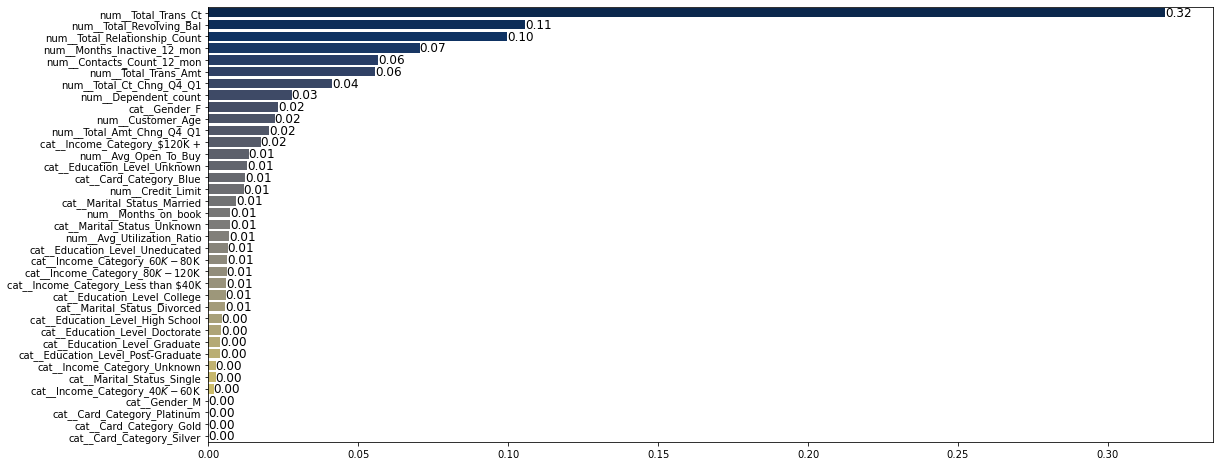

In [56]:
indices = np.argsort(xgb_model.feature_importances_)[::-1]
feature_names = preprocessor.get_feature_names_out()
plt.figure(figsize=[18,8])
ax = sns.barplot(y = feature_names,x = xgb_model.feature_importances_,order=feature_names[indices],palette=('cividis'))
ax.bar_label(ax.containers[0], size="12",fmt='%.2f');

The most important features seem to be Total_Trans_Ct, Total_Revolving_Bal and Total_Relationship_Count. For now, we'll keep all the features in to see what kind of a model we get.

## Let's evaluate the model

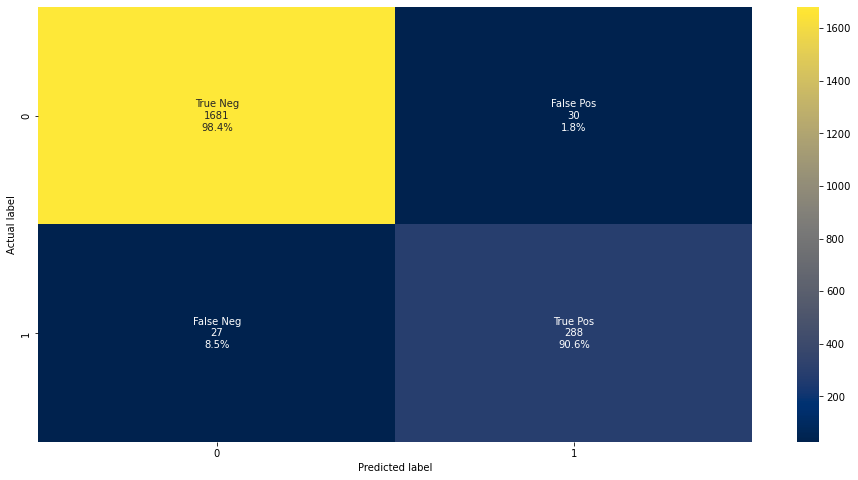

In [25]:
def plot_confusion(y_pred,y_test):
    cm = confusion_matrix(y_pred,y_test)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
            cm.flatten()]
    group_percentages = ["{0:.1%}".format(value) for value in
            cm.flatten()/ np.repeat([y_test.value_counts()[0],y_test.value_counts()[1]],2)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize=[16,8])
    sns.heatmap(cm, annot=labels, fmt='',cmap='cividis')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

plot_confusion(xgb_model.predict(X_test),y_test)

The confusion matrix shows us that our model is already quite good at predicting the churn of a customer. True positive and true negative rates are both over 90%.
           

In [26]:
def plot_roc(target_test,test_preds):
    fpr, tpr, threshold = roc_curve(target_test, test_preds)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=[16,8])
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'Class 1 AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

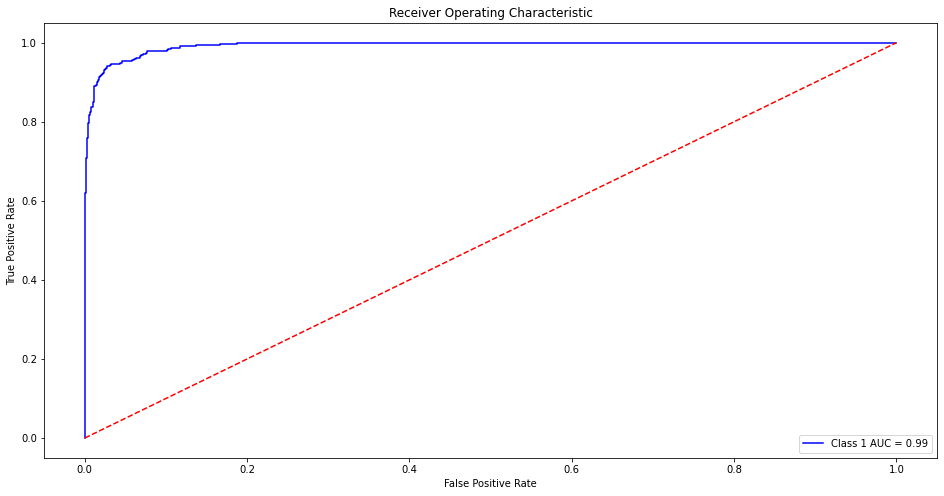

In [27]:
plot_roc(y_test,xgb_model.predict_proba(X_test)[:,1])

The Receiver Operating Characteristic (ROC) curve shows that the Area Under Curve (AUC) score is almost 100%. The ROC curve implies that our model is working really well, as it can find a suitable threshold for classifying the labels. This is because the true positive rate can be made high, and at the same time False positive rate made low.

## Hyperparameter tuning

In [50]:
# CV takes 6 minutes to run on my computer
parameters = {'learning_rate': [0.25,0.3,0.4],
              'max_depth': [6,9],
              'min_child_weight': [1,5],
              'n_estimators': [50,100,150]}


xgb_cv = GridSearchCV(xgb_model, parameters, 
                   cv=5, 
                   scoring='f1',
                   verbose=0)

xgb_cv.fit(X_train, y_train)

print("With parameters",xgb_cv.best_params_)
print("We get an F1 score of:",round(xgb_cv.best_score_,2))

With parameters {'learning_rate': 0.25, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 50}
We get an F1 score of: 0.96


Confusion matrix and ROC curve with the best hyperparameters 

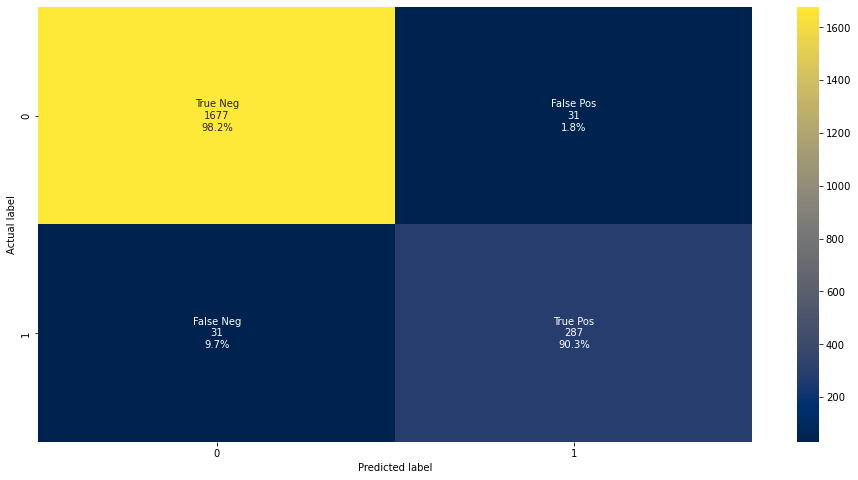

In [44]:
plot_confusion(xgb_cv.predict(X_test),y_test)

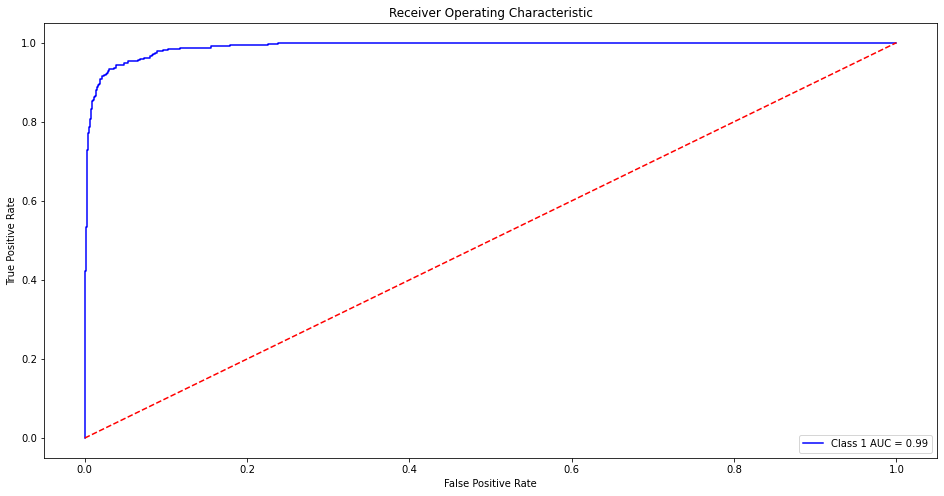

In [47]:
plot_roc(y_test,xgb_cv.predict_proba(X_test)[:,1])

Not much of an improvement regarding AUC. The False Negative rate is higher than with the baseline model.
Seems like our baseline model was quite good already from the start, and that hyperparameter tuning is not that necessary in our case.

## Conclusion

We managed to create a model that predicts whether a customer will churn out. The model has a high accuracy (>90%), and works sufficiently for our case.

Using the knowledge of which customers are predicted to churn out could be utilized to focus on their customer experience. We could try persuade the customers to stay with us by using targeted campaigns or benefits.
